In [1]:
import warnings
warnings.filterwarnings("ignore")
import mindspore 
import mindspore as ms
from mindspore import nn, ops, Tensor
from mindspore.train import Model
import mindspore.numpy as mnp
import numpy as np
import sys, os
from mindcos.operators.derivatives import grad
import time
import scipy.special as sc

In [2]:
#基于毕奥萨法尔定理模拟磁场产生
class data_generation:
    def __init__(self, radius=1, N_sample=16, N_test=1000, L=0.5):
        '''
            radius: 模拟载流线圈半径
            N_sample: 立方体6个面上每个面的采样点数目
            N_test: 测试点数目
            L: 采样立方体的边长/2
        '''
        self.N_sample = N_sample
        self.N_test = N_test
        self.L = L
        self.radius  = radius

    def standard(self, data, labels):
        '''
            数据标准化
        '''
        mean = 0
        std = 0
        mean = labels.mean()
        std  = labels.std()
        standard_labels = ((labels - mean)/std)
        self.mean = mean
        self.std = std

        maxi = self.L
        self.maxi = maxi
        standard_data = (data / maxi)
        return standard_data, standard_labels

    def circB(self,x,y,z):
        '''
            单个载流线圈产生的磁场大小（无量纲，可任意缩放）
        '''
        scale_factor=50
        x_prime=x
        y_prime=y
        z_prime=z
        r_sq_prime = x_prime**2 + y_prime**2 + z_prime**2
        rho_sq_prime = x_prime**2 + y_prime**2
        alpha_sq_prime = self.radius**2 + r_sq_prime - 2. * np.sqrt(rho_sq_prime)*self.radius
        beta_sq_prime = self.radius**2 + r_sq_prime + 2. * np.sqrt(rho_sq_prime)*self.radius
        k_sq_prime = 1. - alpha_sq_prime / beta_sq_prime

        # 计算椭圆积分
        e_k_sq_prime = sc.ellipe(k_sq_prime)
        k_k_sq_prime = sc.ellipk(k_sq_prime)

        # 计算旋转后的磁场分量
        Bx_prime = x_prime * z_prime / (2*alpha_sq_prime * rho_sq_prime * np.sqrt(beta_sq_prime)) * ((self.radius**2 + r_sq_prime) * e_k_sq_prime - alpha_sq_prime * k_k_sq_prime)
        By_prime = y_prime * Bx_prime / x_prime
        Bz_prime = 1 / (2*alpha_sq_prime * np.sqrt(beta_sq_prime)) * ((self.radius**2 - r_sq_prime) * e_k_sq_prime + alpha_sq_prime * k_k_sq_prime)

        return np.array([Bx_prime,By_prime,Bz_prime])*scale_factor

    def B(self,x,y,z):
        '''
            多个线圈排布组成的叠加磁场
        '''
        field = 0.6*self.circB(x + 1.01,y + 1.0,z - 4.0) + 0.2*self.circB(x - 1.01,y - 1.0, z - 4.0) - 0.8*self.circB(x + 1.01,y - 1.0,z - 4.0) - 0.5*self.circB(x - 1.01,y + 1.0,z - 4.0) - 0.98*self.circB(x + 1.01,y + 1.0,z + 4.0) - 0.46*self.circB(x - 1.01,y - 1.0,z + 4.0) + 0.35*self.circB(x + 1.01,y - 1.0,z + 4.0) + 0.87*self.circB(x - 1.01,y + 1.0,z + 4.0)
        return field.tolist()


    def train_data(self, x=None, y=None, z=None):
        '''
            生成训练数据
        '''
        L1 = self.L
        N = self.N_sample
        if (x==None and y==None and z==None):
            x = np.concatenate((-L1 * np.ones([N, 1]), L1 * np.ones([N, 1]), 
                            np.random.default_rng().uniform(low=-L1, high=L1, size=(4 * N, 1))),
                           axis=0)
            y = np.concatenate((np.random.default_rng().uniform(low=-L1, high=L1, size=(2 * N, 1)),
                            -L1 * np.ones([N, 1]), L1 * np.ones([N, 1]),
                            np.random.default_rng().uniform(low=-L1, high=L1, size=(2 * N, 1))),
                           axis=0)
            z = np.concatenate((np.random.default_rng().uniform(low=-L1, high=L1, size=(4 * N, 1)),
                            -L1 * np.ones([N, 1]), L1 * np.ones([N, 1])),
                           axis=0)

        x = Tensor(x, ms.float32)
        y = Tensor(y, ms.float32)
        z = Tensor(z, ms.float32)
        pos = ms.ops.Concat(1)([x, y, z])
        labels = Tensor(np.array([self.B(x[i].asnumpy(), y[i].asnumpy(), z[i].asnumpy()) for i in range(len(x))]), ms.float32).squeeze()
        standard_pos, standard_labels = self.standard(pos, labels)
        return pos, labels, standard_pos, standard_labels

    def test_data(self, x=None, y=None, z=None):
        '''
            生成测试数据
        '''
        L = self.L
        N = self.N_test
        if (x==None and y==None and z==None):
            x = np.random.default_rng().uniform(low=-L, high=L, size=((N, 1)))
            y = np.random.default_rng().uniform(low=-L, high=L, size=((N, 1)))
            z = np.random.default_rng().uniform(low=-L, high=L, size=((N, 1)))
        x = Tensor(x, ms.float32)
        y = Tensor(y, ms.float32)
        z = Tensor(z, ms.float32)
        pos = ms.ops.Concat(1)([x, y, z])
        labels = Tensor(np.array([self.B(x[i].asnumpy(), y[i].asnumpy(), z[i].asnumpy()) for i in range(len(x))]), ms.float32).squeeze()
        maxi = self.maxi
        standard_pos = (pos / maxi)
        standard_labels = (labels - self.mean)/self.std
        return pos, labels, standard_pos, standard_labels

In [3]:
#数据生成
data = data_generation()
train_data, train_labels, standard_train_data, standard_train_labels = data.train_data()
test_data , test_labels, standard_test_data, standard_test_labels  = data.test_data()
x = standard_train_data[:,0]
y = standard_train_data[:,1]
z = standard_train_data[:,2]
Bx = standard_train_labels[:,0]
By = standard_train_labels[:,1]
Bz = standard_train_labels[:,2]
tx, ty, tz = standard_test_data[:,0], standard_test_data[:,1], standard_test_data[:,2]
tBx, tBy, tBz = standard_test_labels[:,0], standard_test_labels[:,1], standard_test_labels[:,2]

[WARNING] DEVICE(158702,ffffb5251020,python):2025-11-04-15:53:21.579.031 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:149] CheckVmmDriverVersion] Open file /etc/ascend_install.info failed.
[WARNING] DEVICE(158702,ffffb5251020,python):2025-11-04-15:53:21.579.112 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:177] CheckVmmDriverVersion] Open file /usr/local/Ascend/driver/version.info failed.


In [4]:
#定义网络和激活函数
def sine_activation(x):
    return ops.Sin()(x)

class PINN(nn.Cell):
    def __init__(self, units, activation=sine_activation):
        super(PINN, self).__init__()
        self.hidden_layer1 = nn.Dense(3, units)
        self.hidden_layer2 = nn.Dense(units, units)
        self.hidden_layer3 = nn.Dense(units, units)
        self.hidden_layer4 = nn.Dense(units, units)
        self.hidden_layer5 = nn.Dense(units, 3)
        self.activation = activation

    def construct(self, x, y, z):
        inputs = ops.cat((x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)), axis=1)
        h1 = self.hidden_layer1(inputs)
        
        h1 = self.activation(h1)
        h2 = self.hidden_layer2(h1)
        h2 = self.activation(h2)
        h3 = self.hidden_layer3(h2 + h1)
        h3 = self.activation(h3)
        h4 = self.hidden_layer4(h3 + h2 + h1)
        h4 = self.activation(h4)
        h5 = self.hidden_layer5(h4 + h3 + h2 + h1)
        Bx = h5[:,0]
        By = h5[:,1]
        Bz = h5[:,2]
        return Bx, By, Bz

In [5]:
network = PINN(32)
optimizer = nn.optim.AdamWeightDecay(network.trainable_params(), learning_rate=0.001)

In [6]:
#定义损失函数，利用麦克斯韦方程中的磁场散度和旋度公式定义物理损失和边界损失
class PINN_Loss(nn.Cell):
    def __init__(self, N_f, L):
        super(PINN_Loss, self).__init__()
        self.N_f = N_f
        self.L = L

    def curl_div(self, x, y, z, model):
        '''
            散度和旋度计算
        '''
        dBx_dxyz_fn = grad(model, 0)
        dBy_dxyz_fn = grad(model, 1)
        dBz_dxyz_fn = grad(model, 2)
        dBx_dx, dBx_dy, dBx_dz = dBx_dxyz_fn(x, y ,z)
        dBy_dx, dBy_dy, dBy_dz = dBy_dxyz_fn(x, y ,z)
        dBz_dx, dBz_dy, dBz_dz = dBz_dxyz_fn(x, y ,z)
        
        curl_x = dBz_dy - dBy_dz  
        curl_y = dBx_dz - dBz_dx  
        curl_z = dBy_dx - dBx_dy  
        loss_curl = (curl_x**2+curl_y**2+curl_z**2).mean()
        loss_div  = ((dBx_dx + dBy_dy + dBz_dz)**2).mean()
        return loss_curl, loss_div
        
    def construct(self, x, y, z, Bx, By, Bz, model):
        loss_BC_curl, loss_BC_div = self.curl_div(x,y,z,model) #边界处的散度和旋度损失
        
        pred_x, pred_y, pred_z = model(x, y, z)
        loss_b_x = ops.ReduceMean()(ops.Pow()(pred_x - Bx, 2))
        loss_b_y = ops.ReduceMean()(ops.Pow()(pred_y - By, 2))
        loss_b_z = ops.ReduceMean()(ops.Pow()(pred_z - Bz, 2))
        loss_b = ops.Sqrt()(loss_b_x + loss_b_y + loss_b_z) #数据损失

        L = self.L
        N_f = self.N_f
        x_f = Tensor(np.random.uniform(-L, L, (N_f, 1))).astype(mindspore.float32)
        y_f = Tensor(np.random.uniform(-L, L, (N_f, 1))).astype(mindspore.float32)
        z_f = Tensor(np.random.uniform(-L, L, (N_f, 1))).astype(mindspore.float32)

        loss_curl, loss_div = self.curl_div(x_f, y_f, z_f, model) #配点的散度和旋度损失
        
        loss = loss_b + loss_div + loss_curl + loss_BC_div + loss_BC_curl #最终的网络损失函数
        
        return loss_b, loss_div, loss_curl, loss_BC_div, loss_BC_curl, loss  

In [7]:
loss_fn = PINN_Loss(32, 0.5)

In [8]:
def forward_fn(x,y,z, Bx,By,Bz):
    loss_b, loss_div, loss_cul, loss_BC_div, loss_BC_cul, loss  = loss_fn(x,y,z,Bx,By,Bz,network)
    return loss_b, loss_div, loss_cul, loss_BC_div, loss_BC_cul, loss

In [9]:
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

In [10]:
def train_step(x,y,z, Bx,By,Bz):
    (loss_b, loss_div, loss_cul, loss_BC_div, loss_BC_cul, loss), grads = grad_fn(x,y,z,Bx,By,Bz)
    optimizer(grads)
    return loss_b, loss_div, loss_cul, loss_BC_div, loss_BC_cul, loss

In [11]:
def train_loop(model, x,y,z, Bx,By,Bz):
    model.set_train()
    loss_b, loss_div, loss_cul, loss_BC_div, loss_BC_cul, loss = train_step(x,y,z, Bx,By,Bz)
    return loss_b, loss_div, loss_cul, loss_BC_div, loss_BC_cul, loss
def test_loop(model, x, y, z, Bx, By, Bz):
    model.set_train(False)
    pred_x, pred_y, pred_z = model(x, y, z)
    loss_b_x = ops.ReduceMean()(ops.Pow()(pred_x - Bx, 2))
    loss_b_y = ops.ReduceMean()(ops.Pow()(pred_y - By, 2))
    loss_b_z = ops.ReduceMean()(ops.Pow()(pred_z - Bz, 2))
    loss_test = ops.Sqrt()(loss_b_x + loss_b_y + loss_b_z)
    return loss_test

In [12]:
device_target = mindspore.context.get_context("device_target")
print("当前设备目标:", device_target)
train_loss = []
test_loss = []
st = time.time()
mini_loss = 10000
log_dir = './log/FieldPrediction'
os.makedirs(log_dir, exist_ok=True)
with open(f'{log_dir}/train.log', 'a') as f:
    f.write('\nepoch, loss_b, loss_div, loss_curl, loss_BC_div, loss_BC_curl, loss, loss_test\n')
best_model = None
for t in range(10000):
    loss_b, loss_div, loss_cul, loss_BC_div, loss_BC_cul, loss = train_loop(network, x, y, z, Bx, By, Bz)
    train_loss.append([loss_b, loss_div, loss_cul, loss_BC_div, loss_BC_cul, loss])
    loss_test = test_loop(network, tx, ty, tz, tBx, tBy, tBz)
    test_loss.append(loss_test)
    if loss_test<mini_loss:
        mini_loss = loss_test
        mindspore.save_checkpoint(network, f'{log_dir}/magnetic_PINN_best.ckpt')
    if((t+1)%100==0):
        print(f"Epoch {t+1} {time.time()-st:.1f}\n-------------------------------")
        print(loss_b, loss_div, loss_cul, loss_BC_div, loss_BC_cul, loss, loss_test)
        with open(f'{log_dir}/train.log', 'a') as f:
            f.write(f'{t+1}, {loss_b}, {loss_div}, {loss_cul}, {loss_BC_div}, {loss_BC_cul}, {loss}, {loss_test}\n')

当前设备目标: Ascend
.Epoch 100 15.4
-------------------------------
0.0598596 0.016588468 0.015187809 0.037794612 0.09094885 0.22037934 0.07668877
Epoch 200 23.8
-------------------------------
0.022531062 0.003969364 0.006493257 0.0152799105 0.032310396 0.08058399 0.03945339
Epoch 300 32.1
-------------------------------
0.018594675 0.0024221228 0.004851548 0.01059858 0.021272592 0.05773952 0.034025937
Epoch 400 40.1
-------------------------------
0.015995272 0.002186485 0.0040276553 0.008296136 0.016650185 0.04715573 0.031291693
Epoch 500 48.1
-------------------------------
0.014838529 0.0021247868 0.0028676584 0.0069414075 0.0144180395 0.041190423 0.024683962
Epoch 600 55.2
-------------------------------
0.013421489 0.0017809945 0.0030305088 0.0059045358 0.012318167 0.036455695 0.025704328
Epoch 700 62.7
-------------------------------
0.012680922 0.0015240752 0.00256192 0.005265621 0.011209483 0.03324202 0.021462377
Epoch 800 70.2
-------------------------------
0.012019116 0.0012941

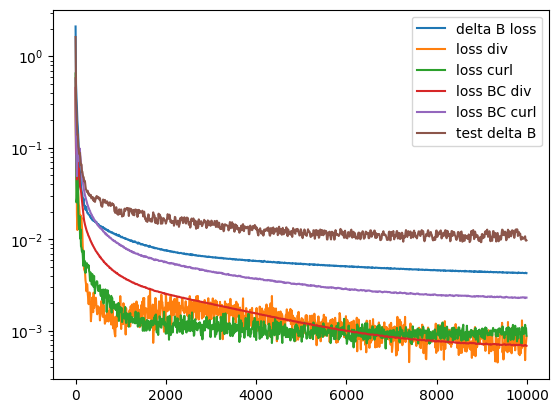

In [13]:
#loss 曲线
import matplotlib.pyplot as plt
plt.plot([i*10+1 for i in range(1000)], [train_loss[i*10][0] for i in range(1000)], label='delta B loss')
plt.plot([i*10+1 for i in range(1000)], [train_loss[i*10][1] for i in range(1000)], label='loss div')
plt.plot([i*10+1 for i in range(1000)], [train_loss[i*10][2] for i in range(1000)], label='loss curl')
plt.plot([i*10+1 for i in range(1000)], [train_loss[i*10][3] for i in range(1000)], label='loss BC div')
plt.plot([i*10+1 for i in range(1000)], [train_loss[i*10][4] for i in range(1000)], label='loss BC curl')
plt.plot([i*10+1 for i in range(1000)], [test_loss[i*10] for i in range(1000)], label='test delta B')
plt.yscale('log')
plt.legend()
plt.savefig(f'{log_dir}/loss.png')

.

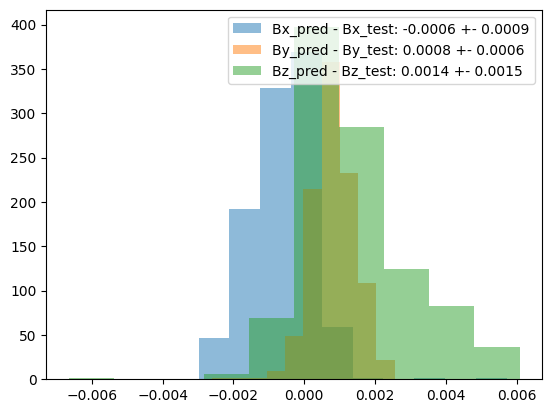

In [14]:
# 绝对误差
Bx_test_pred, By_test_pred, Bz_test_pred = network(tx, ty, tz)
Bx_test_pred = Bx_test_pred * data.std + data.mean
By_test_pred = By_test_pred * data.std + data.mean
Bz_test_pred = Bz_test_pred * data.std + data.mean
Bx_test_lab  = tBx * data.std + data.mean
By_test_lab  = tBy * data.std + data.mean
Bz_test_lab  = tBz * data.std + data.mean
plt.hist((Bx_test_pred-Bx_test_lab).tolist(), label=f'Bx_pred - Bx_test: {(Bx_test_pred-Bx_test_lab).mean().tolist():.4f} +- {(Bx_test_pred-Bx_test_lab).std().tolist():.4f}', alpha=0.5)
plt.hist((By_test_pred-By_test_lab).tolist(), label=f'By_pred - By_test: {(By_test_pred-By_test_lab).mean().tolist():.4f} +- {(By_test_pred-By_test_lab).std().tolist():.4f}', alpha=0.5)
plt.hist((Bz_test_pred-Bz_test_lab).tolist(), label=f'Bz_pred - Bz_test: {(Bz_test_pred-Bz_test_lab).mean().tolist():.4f} +- {(Bz_test_pred-Bz_test_lab).std().tolist():.4f}', alpha=0.5)
plt.legend()
plt.savefig(f'{log_dir}/test_result.png')

In [15]:
#在空间网格上取点，验证网络预测效果
N_val = 10 #网格数10*10*10
L = 0.5
x_test_np_grid = np.linspace(-L, L, N_val)
y_test_np_grid = np.linspace(-L, L, N_val)
z_test_np_grid = np.linspace(-L, L, N_val)
xx, yy, zz = np.meshgrid(x_test_np_grid, y_test_np_grid, z_test_np_grid, sparse=False)
x_test_np = xx.reshape((N_val**3, 1)).tolist()
y_test_np = yy.reshape((N_val**3, 1)).tolist()
z_test_np = zz.reshape((N_val**3, 1)).tolist()

In [16]:
#根据生成函数产生磁场真值
pos, labels, standard_pos, standard_labels = data.test_data(x_test_np,y_test_np,z_test_np)
labelBx = labels.reshape(N_val, N_val, N_val, 3)[:,:,:,0]
labelBy = labels.reshape(N_val, N_val, N_val, 3)[:,:,:,1]
labelBz = labels.reshape(N_val, N_val, N_val, 3)[:,:,:,2]

In [17]:
#根据网络产生预测值
predBx, predBy, predBz = network(Tensor(x_test_np)/data.maxi, Tensor(y_test_np)/data.maxi, Tensor(z_test_np)/data.maxi)
predBx = predBx.reshape(N_val, N_val, N_val)*data.std+data.mean
predBy = predBy.reshape(N_val, N_val, N_val)*data.std+data.mean
predBz = predBz.reshape(N_val, N_val, N_val)*data.std+data.mean

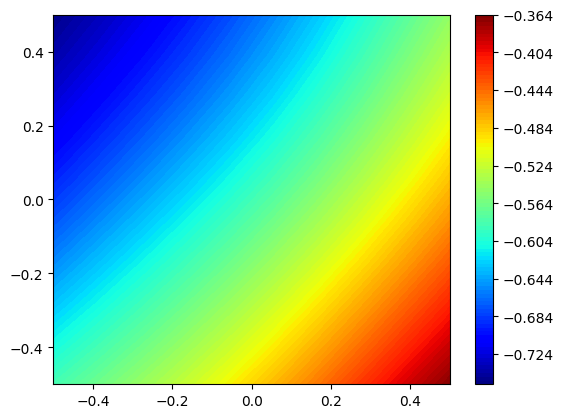

In [18]:
#画出磁场预测值：z=0时的xy平面，z方向磁场
CS = plt.contourf(xx[:,:,0],yy[:,:,0], predBz[:,:,5].tolist(), 100, cmap='jet')
plt.colorbar(CS)

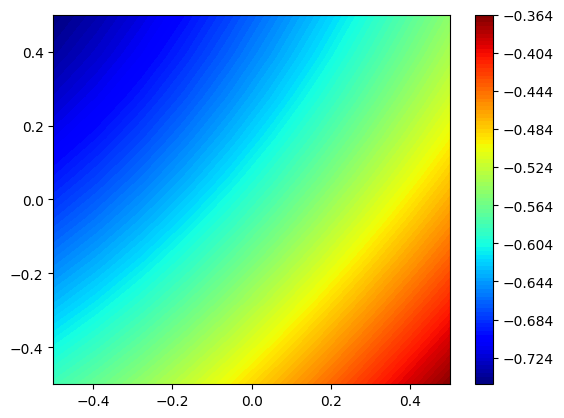

In [19]:
#画出磁场真值：z=0时的xy平面，z方向磁场
labels=labels.reshape(N_val,N_val,N_val,3)
CS = plt.contourf(xx[:,:,0],yy[:,:,0], labelBz[:,:,5].tolist(), 100, cmap='jet')
plt.colorbar(CS)

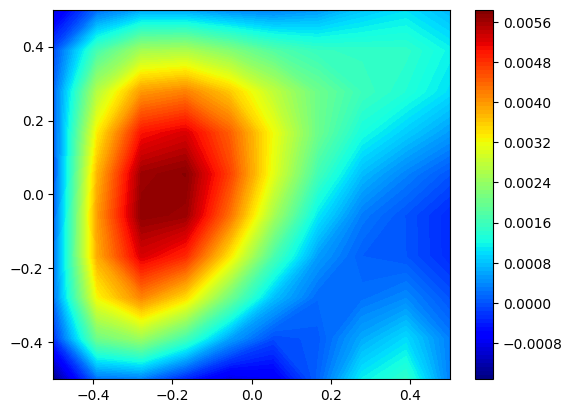

In [20]:
#画出相对误差
CS = plt.contourf(xx[:,:,0],yy[:,:,0], (predBz[:,:,5]-labelBz[:,:,5]).tolist(), 100, cmap='jet')
plt.colorbar(CS)

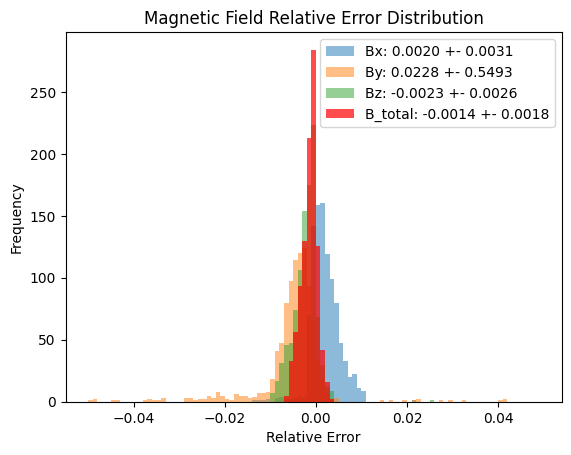

In [24]:
# 磁场相对误差在千分之一量级
Bx_test_pred, By_test_pred, Bz_test_pred = network(tx, ty, tz)
Bx_test_pred = Bx_test_pred * data.std + data.mean
By_test_pred = By_test_pred * data.std + data.mean
Bz_test_pred = Bz_test_pred * data.std + data.mean
Bx_test_lab  = tBx * data.std + data.mean
By_test_lab  = tBy * data.std + data.mean
Bz_test_lab  = tBz * data.std + data.mean

# 计算各分量相对误差
xhist = ((Bx_test_pred-Bx_test_lab)/Bx_test_lab)
yhist = ((By_test_pred-By_test_lab)/By_test_lab)
zhist = ((Bz_test_pred-Bz_test_lab)/Bz_test_lab)

# 计算磁场总量和相对误差
B_total_pred = ops.sqrt(Bx_test_pred**2 + By_test_pred**2 + Bz_test_pred**2)
B_total_lab = ops.sqrt(Bx_test_lab**2 + By_test_lab**2 + Bz_test_lab**2)
total_hist = ((B_total_pred - B_total_lab) / B_total_lab)

bins = [-0.05+0.001*i for i in range(100)]
plt.hist(xhist.asnumpy(), bins=bins, label=f'Bx: {xhist.mean().asnumpy():.4f} +- {xhist.std().asnumpy():.4f}', alpha=0.5)
plt.hist(yhist.asnumpy(), bins=bins, label=f'By: {yhist.mean().asnumpy():.4f} +- {yhist.std().asnumpy():.4f}', alpha=0.5)
plt.hist(zhist.asnumpy(), bins=bins, label=f'Bz: {zhist.mean().asnumpy():.4f} +- {zhist.std().asnumpy():.4f}', alpha=0.5)
plt.hist(total_hist.asnumpy(), bins=bins, label=f'B_total: {total_hist.mean().asnumpy():.4f} +- {total_hist.std().asnumpy():.4f}', alpha=0.7, color='red')

plt.legend()
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.title('Magnetic Field Relative Error Distribution')
plt.savefig(f'{log_dir}/test_all_components_relative_result.png')
plt.show()